# MLFlow runs

In [36]:
import mlflow
import seaborn as sns

mlflow.tracking.set_tracking_uri('../mlruns')

labels_methods = {
    'cam': 'CAM', 'gradcam': 'Grad-CAM', 'gradcam++': 'Grad-CAM++', 'scorecam': 'Score-CAM', 'minmaxcam': 'MinMaxCAM'}

## Functions

In [2]:
from mlflow import MlflowClient

def mlflow_create_filter(conditions=None):
    if conditions is None:
        return ''
    keys = conditions.keys()
    values = [ f'"{v}"' if type(v) == str else v for v in conditions.values()]
    filter = ' AND '.join([f'{k} = {v}' for k,v in zip(keys, values)])
    return filter

def mlflow_get_runs(experiment_name, conditions=None):
    client = MlflowClient()
    exp_ids = [client.get_experiment_by_name(experiment_name).experiment_id]
    filter = mlflow_create_filter(conditions)
    runs = mlflow.search_runs(experiment_ids=exp_ids, filter_string=filter)
    return runs

def get_runs(experiment_name, filter=''):
    client = MlflowClient()
    exp_ids = [client.get_experiment_by_name(experiment_name).experiment_id]
    runs = mlflow.search_runs(experiment_ids=exp_ids, filter_string=filter)
    return runs

def get_best_run(runs, best_metrics):
    if runs is None or runs.shape[0] == 0:
        return None
    for metric in best_metrics:
        runs = runs.loc[runs[f'metrics.{metric}'] >= runs[f'metrics.{metric}'].max()]
    # pick first in the list
    run = runs.loc[runs.index[0]]
    return run

In [13]:
import matplotlib.pyplot as plt
import os, json
import numpy as np

def get_mlflow_boxacc_prcurve(experiment_name = 'wsol2', conditions=None, split='test', box_metric='MaxBoxAccV3', mask_metric=None):
    boxacc = {}
    prcurve = {}
    iou_thresholds = [30, 50, 70]
    runs = mlflow_get_runs(experiment_name, conditions)
    for row in runs.itertuples(index=False):
        artifact_uri = row.artifact_uri
        artifact_path = artifact_uri[len('file://'):]
        config_path = os.path.join(artifact_path, 'state/config.json')
        with open(config_path) as fp:
            _config = json.load(fp)
        boxacc[_config['wsol_method']] = {}
        for iou_threshold in iou_thresholds:
            boxacc_path = os.path.join(artifact_path, f'data/{split}/{box_metric}_box_acc_iou_{iou_threshold}.json')
            with open(boxacc_path) as fp:
                _boxacc = json.load(fp)
                values = {k: _boxacc[k] for k in ['cam_threshold', 'box_accuracy']}
                boxacc[_config['wsol_method']][iou_threshold] = values
        if mask_metric is not None:
            prcurve_path = os.path.join(artifact_path, f'data/{split}/pr_curve.json')
            with open(prcurve_path) as fp:
                # _prcurve = json.load(fp)
                # values = {k: _prcurve[k] for k in ['precision', 'recall']}
                prcurve[_config['wsol_method']] = json.load(fp)
        else:
            prcurve = None
    return boxacc, prcurve

def plot_boxacc(boxacc, title, iou_thresholds=None):
    # plot lines
    if iou_thresholds is None:
        iou_thresholds = [30, 50, 70]
    for method, iou_values in boxacc.items():
        for iou_threshold, values in iou_values.items():
            if iou_threshold not in iou_thresholds:
                continue
            x = np.asarray(values['cam_threshold'])
            y = np.asarray(values['box_accuracy'])
            xmax = x[np.argmax(y)]
            ymax = y.max()
            text = f"({xmax:.2f}, {ymax:.2f})"
            lb_method = labels_methods[method]
            label = lb_method if len(iou_thresholds) == 1 else f'{lb_method} {iou_threshold}'
            label = f'{label} {text}'
            plt.plot(x, y, label=label)
            plt.plot(xmax, ymax, 'ro')
            # plt.text(xmax + 0.01, ymax + 0.01, text)
    plt.xlabel("Score map threshold")
    plt.ylabel("BoxAcc")
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.title(title)
    plt.legend()
    plt.show()

def plot_prcurve(curve, title):
    # plot lines
    for method, values in curve.items():
        label = f"{method} (auc {values['auc']:.2f})"
        plt.plot(values['recall'], values['precision'], label=label)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.title(title)
    plt.legend()
    plt.show()

In [15]:
import pandas as pd

def mlflow_runs_to_latex(experiment_name, conditions=None, split='test', metrics=None, label='', caption=''):
    if conditions is not None and 'tags.dataset' in conditions and conditions['tags.dataset'] == 'SYNTHETIC':
        dataset = 'SYNTHETIC'
    else:
        dataset = 'ILSVRC'
    if metrics is None:
        metrics = ['MaxBoxAcc', 'MaxBoxAccV2', 'MaxBoxAccV3']
        if dataset == 'SYNTHETIC':
            metrics.append('PxAP')
    runs = mlflow_get_runs(experiment_name, conditions=conditions)
    if experiment_name == 'mwsol_resnet50_imagenet':
        runs = runs.loc[runs.start_time > '2023-05-01']
    cols_metrics = [f'metrics.{split}_{metric}' for metric in metrics]
    cols = ['tags.method', 'tags.architecture', 'tags.architecture_type', 'tags.dataset', 'tags.dataset_spec'] + cols_metrics
    cols_renamed = [c.split('.')[-1] for c in cols]
    mapper = dict(zip(cols, cols_renamed))
    df = runs.loc[:, cols].rename(columns=mapper)
    mapper = dict([(f'{split}_{metric}', metric) for metric in metrics])
    df = df.loc[:, df.columns].rename(columns=mapper)
    # df.loc[:, 'dataset'] = df['dataset'].str.cat(df['dataset_spec'], sep='\_').str.lower()
    # pd.set_option("display.precision", 2)
    for metric in metrics:
        df[metric] *= 100 # to percentage
    if dataset == 'SYNTHETIC':
        specs = df['dataset_spec'].unique()
        cols_pivot = ['dataset_spec']
        df = df.pivot(index='method', columns=cols_pivot, values=metrics)
        cols = metrics
        df = df.loc[:, cols]
        df = df.sort_index()
        latex_table = df.to_latex(float_format="%.2f", multicolumn=True,
                              label=label, caption=caption, position="ht")

        cols_format = dict([((m, spec), '{:.2f}') for m in metrics for spec in specs])
        s = df.style
        s = s.format(cols_format)
        s = s.highlight_max(subset=metrics, axis=0, props='bfseries: ;')
        latex_table2 = s.to_latex(
                column_format="lrrrrrrrr", position="ht", position_float="centering",
                hrules=False, label=label, caption=caption,
                multirow_align="t", multicol_align="c")
    else:
        cols = ['method'] + metrics
        df = df.loc[:, cols]
        df = df.sort_values('method')
        latex_table = df.to_latex(float_format="%.2f", multicolumn=True,
                      label=label, caption=caption, position="ht", index=False)

        cols_format = dict([(m, '{:.2f}') for m in metrics])
        s = df.set_index('method').style
        s = s.format(cols_format)
        s = s.highlight_max(subset=metrics, axis=0, props='bfseries: ;')
        latex_table2 = s.to_latex(
                column_format="lrrr", position="ht", position_float="centering",
                hrules=False, label=label, caption=caption,
                multirow_align="t", multicol_align="c")
    print(latex_table)
    print(latex_table2)

## Reports

In [5]:
experiment_name = 'mwsol_vgg16_synthetic'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
df = mlflow_get_runs(experiment_name, conditions=conditions)
cols = ['tags.method', 'tags.dataset', 'tags.dataset_spec', 'tags.architecture', 'tags.architecture_type', 'artifact_uri']
df = df.loc[:, cols]
cols_renamed = [c.split('.')[-1] for c in cols]
df = df.rename(columns=dict(zip(cols,cols_renamed)))
df.loc[:, 'artifact_uri'] = df['artifact_uri'].str.removeprefix('file://')

### MaxBoxAccV3 and PxAP

In [6]:
metric = 'MaxBoxAccV3_precision'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
# conditions |= {
#     'tags.dataset_spec': 'd4b'
# }
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_precision for VGG16-GAP on synthetic}
\label{tb:maxboxaccv3_precision_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
cam & 88.57 & 84.86 & 73.39 & 71.86 & 69.34 & 65.39 & 63.22 & 63.96 \\
gradcam++ & 88.82 & 86.57 & 72.96 & 71.42 & 69.63 & 64.82 & 62.94 & 63.56 \\
minmaxcam & 89.09 & 83.47 & 73.50 & 72.66 & 71.91 & 63.68 & 63.46 & 52.37 \\
scorecam & 87.51 & 78.66 & 76.77 & 71.35 & 74.79 & 69.70 & 64.36 & 63.96 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_precision for VGG16-GAP on synthetic}
\label{tb:maxboxaccv3_precision_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
cam & 88.57 & 84.86 & 73.39 & 71.

In [16]:
metric = 'MaxBoxAccV3'
metric_name = metric if metric is not None else 'Metrics'
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'ILSVRC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3 for ResNet-50 on ImageNet}
\label{tb:maxboxaccv3_resnet50_imagenet}
\begin{tabular}{lr}
\toprule
method & MaxBoxAccV3 \\
\midrule
cam & 36.58 \\
gradcam++ & 37.53 \\
minmaxcam & 36.02 \\
scorecam & 35.92 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3 for ResNet-50 on ImageNet}
\label{tb:maxboxaccv3_resnet50_imagenet}
\begin{tabular}{lrrr}
 & MaxBoxAccV3 \\
method &  \\
cam & 36.58 \\
gradcam++ & \bfseries 37.53 \\
minmaxcam & 36.02 \\
scorecam & 35.92 \\
\end{tabular}
\end{table}



### Localization performance at varying CAM thresholds

In [8]:
path_basedir = '../train_log'
methods = ['cam', 'gradcam++', 'scorecam', 'minmaxcam']
background_filter = 'b'

In [9]:
experiment_name = 'mwsol_vgg16_synthetic'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
runs = mlflow_get_runs(experiment_name, conditions=conditions)
runs = runs.loc[runs['tags.dataset_spec'].str.contains(background_filter)]

In [10]:
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_MaxBoxAcc_f1_IOU_50,metrics.test_MaxBoxAccV3_recall_IOU_50,metrics.test_MaxBoxAcc_optimal_threshold_IOU_30,metrics.test_MaxBoxAccV3_optimal_threshold_IOU_70,...,tags.mlflow.project.entryPoint,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name,tags.optimizer,tags.pretrained,tags.model,tags.mlflow.runName,tags.experiment,tags.train_augment
0,25efa11783df4218a9d57bd166cea872,998329977809601835,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-04-04 18:02:18.438000+00:00,2023-04-04 18:07:34.874000+00:00,0.920,0.542500,0.71,0.60,...,main,"[{""run_id"": ""25efa11783df4218a9d57bd166cea872""...",root,/project/thesis,SGD,True,VggCam,vgg16_gap_minmaxcam_synthetic_d4b,vgg16_gap_minmaxcam_synthetic_d4b,True
2,c844b03070df4759b7cef556bea5f396,998329977809601835,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-04-04 16:21:55.409000+00:00,2023-04-04 16:28:22.927000+00:00,0.945,0.686667,0.65,0.64,...,main,"[{""run_id"": ""c844b03070df4759b7cef556bea5f396""...",root,/project/thesis,SGD,True,VggCam,vgg16_gap_minmaxcam_synthetic_d3b,vgg16_gap_minmaxcam_synthetic_d3b,True
4,f9bc1986e4bb4f57b6c9741fb695d114,998329977809601835,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-04-04 14:27:10.311000+00:00,2023-04-04 14:37:50.396000+00:00,0.940,0.747500,0.66,0.62,...,main,"[{""run_id"": ""f9bc1986e4bb4f57b6c9741fb695d114""...",root,/project/thesis,SGD,True,VggCam,vgg16_gap_minmaxcam_synthetic_d2b,vgg16_gap_minmaxcam_synthetic_d2b,True
6,0ed45a04bcd249cf818faac31bcfb3df,998329977809601835,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-04-04 12:42:06.321000+00:00,2023-04-04 12:47:32.161000+00:00,0.975,0.980000,0.21,0.41,...,main,"[{""run_id"": ""0ed45a04bcd249cf818faac31bcfb3df""...",root,/project/thesis,SGD,True,VggCam,vgg16_gap_minmaxcam_synthetic_d1b,vgg16_gap_minmaxcam_synthetic_d1b,True
8,4a5f8a55182a4265a6568624a5bc1630,998329977809601835,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-04-02 15:01:00.532000+00:00,2023-04-02 15:22:33.433000+00:00,0.915,0.591250,0.68,0.57,...,main,"[{""run_id"": ""4a5f8a55182a4265a6568624a5bc1630""...",root,/project/thesis,SGD,True,VggCam,vgg16_gap_scorecam_synthetic_d4b,vgg16_gap_scorecam_synthetic_d4b,True
10,4536131124ac45418896364fbcbc0814,998329977809601835,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-04-02 14:10:22.695000+00:00,2023-04-02 14:32:04.952000+00:00,0.925,0.758333,0.75,0.61,...,main,"[{""run_id"": ""4536131124ac45418896364fbcbc0814""...",root,/project/thesis,SGD,True,VggCam,vgg16_gap_scorecam_synthetic_d3b,vgg16_gap_scorecam_synthetic_d3b,True
12,eac8230f6acc413eb85da3e3149305d3,998329977809601835,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-04-02 13:18:18.054000+00:00,2023-04-02 13:39:29.086000+00:00,0.935,0.840000,0.60,0.66,...,main,"[{""run_id"": ""eac8230f6acc413eb85da3e3149305d3""...",root,/project/thesis,SGD,True,VggCam,vgg16_gap_scorecam_synthetic_d2b,vgg16_gap_scorecam_synthetic_d2b,True
14,c0698ce23454462291227590edbde23f,998329977809601835,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-04-02 12:55:56.120000+00:00,2023-04-02 13:17:32.581000+00:00,0.975,0.975000,0.20,0.41,...,main,"[{""run_id"": ""c0698ce23454462291227590edbde23f""...",root,/project/thesis,SGD,True,VggCam,vgg16_gap_scorecam_synthetic_d1b,vgg16_gap_scorecam_synthetic_d1b,True
16,1f744062b33d42b68bb8640e5ddb6f27,998329977809601835,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-04-02 12:23:56.424000+00:00,2023-04-02 12:25:03.838000+00:00,0.905,0.531250,0.63,0.59,...,main,"[{""run_id"": ""1f744062b33d42b68bb8640e5ddb6f27""...",root,/project/thesis,SGD,True,VggCam,vgg16_gap_gradcamplusplus_synthetic_d4b,vgg16_gap_gradcamplusplus_synthetic_d4b,True
18,d87c933d60bb4ce7b40abd0b0a230566,998329977809601835,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-04-02 12:22:59.001000+00:00

In [11]:
runs.loc[:, ['tags.method', 'tags.architecture', 'tags.dataset', 'tags.dataset_spec', 'artifact_uri']]

,tags.method,tags.architecture,tags.dataset,tags.dataset_spec,artifact_uri
0,minmaxcam,vgg16,SYNTHETIC,d4b,file:///Users/goemaereg/github.com/thesis/mlru...
2,minmaxcam,vgg16,SYNTHETIC,d3b,file:///Users/goemaereg/github.com/thesis/mlru...
4,minmaxcam,vgg16,SYNTHETIC,d2b,file:///Users/goemaereg/github.com/thesis/mlru...
6,minmaxcam,vgg16,SYNTHETIC,d1b,file:///Users/goemaereg/github.com/thesis/mlru...
8,scorecam,vgg16,SYNTHETIC,d4b,file:///Users/goemaereg/github.com/thesis/mlru...
10,scorecam,vgg16,SYNTHETIC,d3b,file:///Users/goemaereg/github.com/thesis/mlru...
12,scorecam,vgg16,SYNTHETIC,d2b,file:///Users/goemaereg/github.com/thesis/mlru...
14,scorecam,vgg16,SYNTHETIC,d1b,file:///Users/goemaereg/github.com/thesis/mlru...
16,gradcam++,vgg16,SYNTHETIC,d4b,file:///Users/goemaereg/github.com/thesis/mlru...
18,gradcam++,vgg16,SYNTHETIC,d3b,file:///Users/goemaereg/github.com/thesis/mlru...


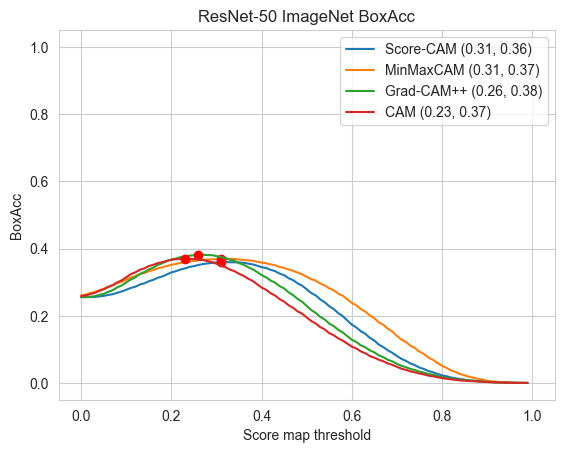

In [14]:
experiment_name = 'mwsol_resnet50_imagenet'
conditions = {
    'tags.dataset': 'ILSVRC',
    'tags.architecture': 'resnet50',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
boxacc, prcurve = get_mlflow_boxacc_prcurve(experiment_name=experiment_name, conditions=conditions, split='val', box_metric='MaxBoxAccV3', mask_metric=None)
# BoxAcc
title = f"ResNet-50 ImageNet BoxAcc"
plot_boxacc(boxacc, title=title, iou_thresholds=[50])
if prcurve is not None:
    # PR Curve
    title = f"ResNet-50 ImageNet PR Curve"
    plot_prcurve(prcurve, title)

In [18]:
dataset = 'SYNTHETIC'
spec = 'd1b'
archtype = 'cam'
experiment_name = 'mwsol_resnet50_synthetic'
run_name = 'resnet50_minmaxcam_synthetic_d1b'
conditions = {
    'tags.dataset': dataset, 'tags.dataset_spec': spec, 'tags.architecture_type': archtype, 'tags.method': 'minmaxcam'}
iou_boxacc, _ = get_mlflow_boxacc_prcurve(experiment_name=experiment_name, conditions=conditions, split='test')

In [19]:
list(iou_boxacc)

['minmaxcam']

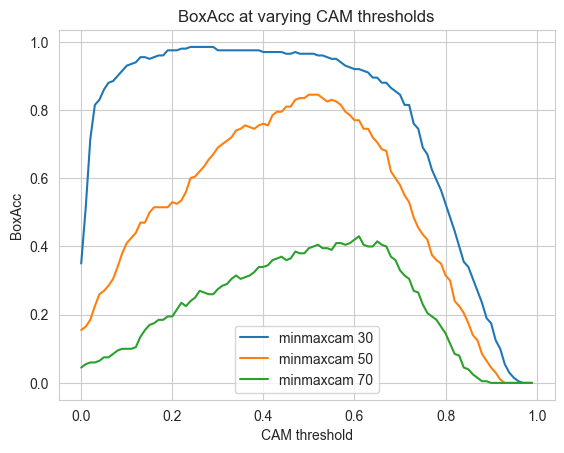

In [20]:
for method, iou_values in iou_boxacc.items():
    for iou_threshold, boxacc in iou_values.items():
        label = f'{method} {iou_threshold}'
        plt.plot(boxacc['cam_threshold'], boxacc['box_accuracy'], label = label)
plt.xlabel("CAM threshold")
plt.ylabel("BoxAcc")
plt.title('BoxAcc at varying CAM thresholds')
plt.legend()
plt.show()

### Training performance

In [21]:
dataset = 'SYNTHETIC'
spec = 'd1b'
archtype = 'cam'
experiment_name = 'wsol_resnet50_synthetic'
run_name = 'resnet50_minmaxcam_synthetic_d1b'
# run_id = '63fa71e18f4849a19f49b2923adf57a3'
# run_id = 'e6f2d6ba4ca24e31ba7b57c2e2d0266b'
conditions = {'tags.mlflow.runName': run_name}
runs = mlflow_get_runs(experiment_name, conditions=conditions)
run_id = runs['run_id'][0]

In [22]:
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_runtime_cam,metrics.val_optimal_threshold_IOU_70,metrics.test_accuracy,metrics.val_accuracy,...,tags.mlflow.project.entryPoint,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name,tags.optimizer,tags.pretrained,tags.model,tags.mlflow.runName,tags.experiment,tags.train_augment
0,df000b8b56444239967892aecd5cc432,965153792060422881,FINISHED,file:///users/goemaereg/github.com/thesis/mlru...,2023-03-02 20:04:04.744000+00:00,2023-03-02 20:25:15.092000+00:00,1108.864159,0.54,1.0,1.000,...,main,"[{""run_id"": ""df000b8b56444239967892aecd5cc432""...",root,/users/goemaereg/github.com/thesis,SGD,True,ResNetCam,resnet50_minmaxcam_synthetic_d1b,resnet50_minmaxcam_synthetic_d1b,True
1,6dcc4de27f924438aec2e5fa9c4cc642,965153792060422881,FINISHED,file:///users/goemaereg/github.com/thesis/mlru...,2023-02-28 14:19:09.861000+00:00,2023-02-28 14:29:35.702000+00:00,987.823067,0.00,1.0,0.995,...,main,"[{""run_id"": ""6dcc4de27f924438aec2e5fa9c4cc642""...",root,/users/goemaereg/github.com/thesis,SGD,True,ResNetCam,resnet50_minmaxcam_synthetic_d1b,resnet50_minmaxcam_synthetic_d1b,True


### Classification versus localization accuracy

In [23]:
from mlflow import MlflowClient

client = MlflowClient()
val_accuracy = [metric.value for metric in client.get_metric_history(run_id, 'val_accuracy')]
steps = list(range(len(val_accuracy)))
val_maxboxaccv3 = [metric.value for metric in client.get_metric_history(run_id, 'val_MaxBoxAccV3')]
val_pxap = [metric.value for metric in client.get_metric_history(run_id, 'val_PxAP')]

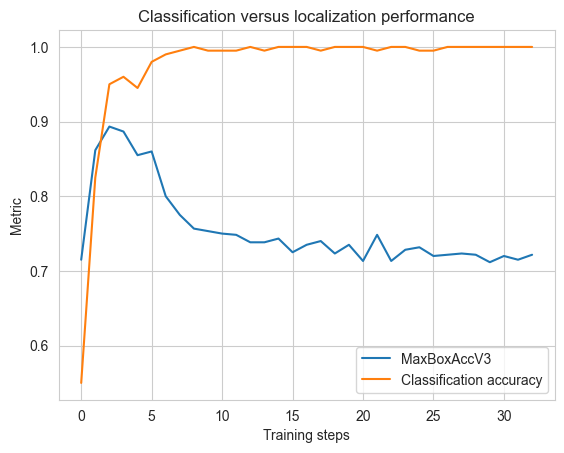

In [24]:
plt.plot(steps, val_maxboxaccv3, label = 'MaxBoxAccV3')
plt.plot(steps, val_accuracy, label='Classification accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Classification versus localization performance')
plt.legend()
plt.show()

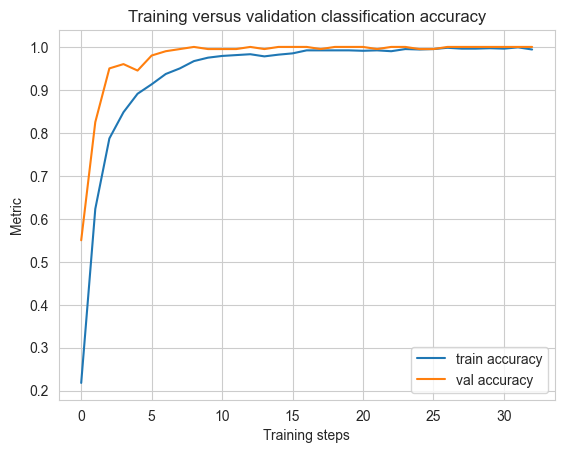

In [25]:
train_accuracy = [metric.value for metric in client.get_metric_history(run_id, 'train_accuracy')]
plt.plot(steps, train_accuracy, label='train accuracy')
plt.plot(steps, val_accuracy, label='val accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Training versus validation classification accuracy')
plt.legend()
plt.show()

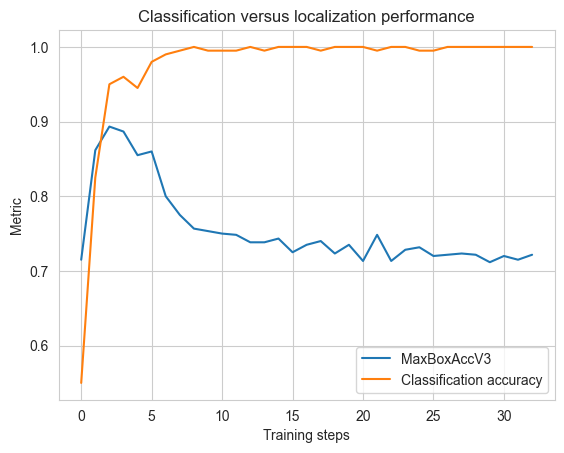

In [26]:
plt.plot(steps, val_maxboxaccv3, label = 'MaxBoxAccV3')
plt.plot(steps, val_accuracy, label='Classification accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Classification versus localization performance')
plt.legend()
plt.show()

### Image annotations

In [27]:
def normalize_scoremap(cam):
    """
    Args:
        cam: numpy.ndarray(size=(H, W), dtype=np.float)
    Returns:
        numpy.ndarray(size=(H, W), dtype=np.float) between 0 and 1.
        If input array is constant, a zero-array is returned.
    """
    if np.isnan(cam).any():
        return np.zeros_like(cam)
    if cam.min() == cam.max():
        return np.zeros_like(cam)
    cam -= cam.min()
    cam /= cam.max()
    return cam

In [28]:
dataset = 'SYNTHETIC'
spec = 'd2b'
architecture = 'vgg16'
archtype = 'cam'
experiment_name = 'mwsol_vgg16_synthetic'
run_name = 'vgg16_gap_cam_synthetic_d2b'
conditions = {'tags.mlflow.runName': run_name}
runs = mlflow_get_runs(experiment_name, conditions=conditions)
run_id = runs['run_id'][0]
experiment_id = runs['experiment_id'][0]
artifact_uri = runs['artifact_uri'][0][len('file://'):]
# config_path = os.path.join(artifact_path, 'state/config.json')

In [29]:
artifact_uri

'/Users/goemaereg/github.com/thesis/mlruns/998329977809601835/46ad4d2bf900458ab4c3318d4b9b6701/artifacts'

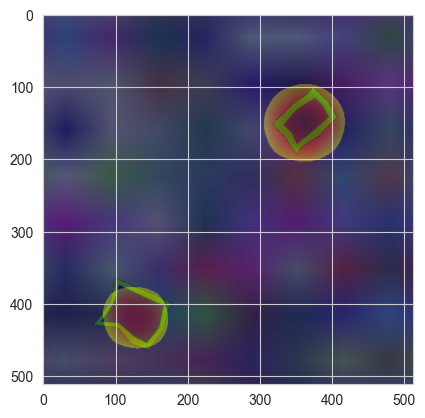

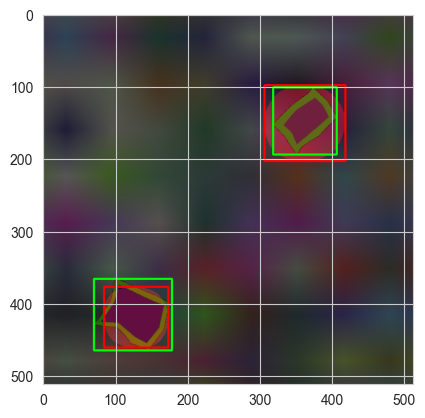

In [30]:
import numpy as np
import cv2

# os.path.join(artifact_uri, 'xai', split, f'SYNTHETIC_d_2_b_{split}_111')
split = 'test'
image_no = 101
path_img = os.path.join(artifact_uri, 'xai', split, f'SYNTHETIC_d_2_b_{split}_{image_no}.png')
# show the image, provide window name first
image = cv2.imread(path_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
path_img = os.path.join(artifact_uri, 'xai', split, f'SYNTHETIC_d_2_b_{split}_{image_no}_ann.png')
# show the image, provide window name first
image = cv2.imread(path_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()


### Iterative localization

In [31]:
experiment_name = 'mwsol_vgg16_synthetic_iter'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.dataset_spec': 'd4b',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'tags.method': 'cam',
    'status': 'FINISHED'
}
# conditions |= {
#     'params.bbox_mask_strategy': 'random',
#     'params.bbox_merge_strategy': 'add',
#     'params.iter_stop_prob_delta': '0.25',
# }
df_runs = mlflow_get_runs(experiment_name, conditions)

In [32]:
import itertools
import numpy as np

label = 'tab:iter_metrics_vgg16_cam_synthetic'
caption = 'Iterative CAM localization metrics for VGG16-GAP on synthetic dataset'
metrics = ['MaxBoxAccV3_recall', 'MaxBoxAccV3_precision', 'MaxBoxAccV3_f1']
metrics_short = ['recall','precision','f1']
split = 'test'

df = df_runs
cols_metrics_mlflow = [f'metrics.{split}_{metric}' for metric in metrics]
cols_params = ['bbox_mask_strategy', 'bbox_merge_strategy', 'iter_stop_prob_delta']
cols_params_mlflow = [f'params.{p}' for p in cols_params]
cols_mlflow = ['tags.method', 'tags.architecture', 'tags.architecture_type', 'tags.dataset', 'tags.dataset_spec']
cols_mlflow += cols_metrics_mlflow + cols_params_mlflow
cols_renamed = [c.split('.')[-1] for c in cols_mlflow]
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
mapper = dict([(f'{split}_{metric}', metric) for metric in metrics])
df = df.rename(columns=mapper)
mapper = dict(zip(metrics, metrics_short))
df = df.rename(columns=mapper)
cols_params_short = ['mask', 'merge', 'stop']
mapper = dict(zip(cols_params, cols_params_short))
df = df.rename(columns=mapper)
# df.loc[:, 'dataset'] = df['dataset'].str.cat(df['dataset_spec'], sep='\_').str.lower()
# pd.set_option("display.precision", 2)
metrics = metrics_short
for metric in metrics:
    df[metric] *= 100 # to percentage
cols_filter = cols_params_short + metrics
df = df.loc[:, cols_filter]
cols_pivot = ['merge']
cols_index = ['stop', 'mask']
pivot_values = [np.sort(df.loc[:, c].unique()).tolist() for c in cols_pivot]
df = df.pivot(index=cols_index, columns=cols_pivot, values=metrics)
iterables = [metrics]
cols_format = dict([(col_index, '{:.2f}') for col_index in itertools.product(metrics, *pivot_values)])
s = df.style
s = s.format(cols_format)
s = s.highlight_max(subset=metrics, axis=0, props='color:{teal}; bfseries: ;')
s = s.highlight_min(subset=metrics, axis=0, props='color:{purple}; bfseries: ;')
latex_table = s.to_latex(
        # column_format="llll" + "r"*len(metrics),
        position="ht", position_float="centering",
        hrules=False, label=label, caption=caption,
        multirow_align="t", multicol_align="c")
print(latex_table)

\begin{table}[ht]
\centering
\caption{Iterative CAM localization metrics for VGG16-GAP on synthetic dataset}
\label{tab:iter_metrics_vgg16_cam_synthetic}
\begin{tabular}{llrrrrrrrrr}
 &  & \multicolumn{3}{c}{recall} & \multicolumn{3}{c}{precision} & \multicolumn{3}{c}{f1} \\
 & merge & add & drop & unify & add & drop & unify & add & drop & unify \\
stop & mask &  &  &  &  &  &  &  &  &  \\
\multirow[t]{3}{*}{0.25} & mean & 54.29 & 52.13 & 52.21 & \color{teal} \bfseries 54.09 & 61.21 & 61.30 & 54.19 & 56.30 & 56.39 \\
 & random & 53.92 & 52.04 & 51.75 & 53.26 & 62.28 & 62.06 & 53.59 & 56.70 & 56.44 \\
 & zero & \color{purple} \bfseries 52.92 & \color{purple} \bfseries 51.00 & \color{purple} \bfseries 50.96 & 53.20 & \color{teal} \bfseries 62.50 & \color{teal} \bfseries 62.31 & 53.06 & 56.17 & 56.07 \\
\multirow[t]{3}{*}{0.5} & mean & 56.75 & 54.29 & 55.71 & 52.41 & 59.86 & 61.02 & \color{teal} \bfseries 54.49 & 56.94 & \color{teal} \bfseries 58.24 \\
 & random & 56.88 & 54.08 & 54.54 & 

In [33]:
import itertools
import numpy as np

label = 'tab:iter_metrics_vgg16_cam_synthetic'
caption = 'Iterative CAM localization metrics for VGG16-GAP on synthetic dataset'
metrics = ['MaxBoxAccV3_recall', 'MaxBoxAccV3_precision', 'MaxBoxAccV3_f1']
metrics_short = ['recall','precision','f1']
split = 'test'

df = df_runs
cols_metrics_mlflow = [f'metrics.{split}_{metric}' for metric in metrics]
cols_params = ['bbox_mask_strategy', 'bbox_merge_strategy', 'iter_stop_prob_delta']
cols_params_mlflow = [f'params.{p}' for p in cols_params]
cols_mlflow = ['tags.method', 'tags.architecture', 'tags.architecture_type', 'tags.dataset', 'tags.dataset_spec']
cols_mlflow += cols_metrics_mlflow + cols_params_mlflow
cols_renamed = [c.split('.')[-1] for c in cols_mlflow]
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
mapper = dict([(f'{split}_{metric}', metric) for metric in metrics])
df = df.rename(columns=mapper)
mapper = dict(zip(metrics, metrics_short))
df = df.rename(columns=mapper)
cols_params_short = ['mask', 'merge', 'stop']
mapper = dict(zip(cols_params, cols_params_short))
df = df.rename(columns=mapper)
# df.loc[:, 'dataset'] = df['dataset'].str.cat(df['dataset_spec'], sep='\_').str.lower()
# pd.set_option("display.precision", 2)
metrics = metrics_short
for metric in metrics:
    df[metric] *= 100 # to percentage
cols_filter = cols_params_short + metrics
df = df.loc[:, cols_filter]
cols_pivot = ['merge']
cols_index = ['stop', 'mask']
pivot_values = [np.sort(df.loc[:, c].unique()).tolist() for c in cols_pivot]
df = df.pivot(index=cols_index, columns=cols_pivot, values=metrics)
cols_format = dict([(col_index, '{:.2f}') for col_index in itertools.product(metrics, *pivot_values)])
s = df.style
s = s.format(cols_format)
s = s.highlight_max(subset=metrics, axis=0, props='color:{teal}; bfseries: ;')
s = s.highlight_min(subset=metrics, axis=0, props='color:{purple}; bfseries: ;')
latex_table = s.to_latex(
        # column_format="llll" + "r"*len(metrics),
        position="ht", position_float="centering",
        hrules=False, label=label, caption=caption,
        multirow_align="t", multicol_align="c")
print(latex_table)

\begin{table}[ht]
\centering
\caption{Iterative CAM localization metrics for VGG16-GAP on synthetic dataset}
\label{tab:iter_metrics_vgg16_cam_synthetic}
\begin{tabular}{llrrrrrrrrr}
 &  & \multicolumn{3}{c}{recall} & \multicolumn{3}{c}{precision} & \multicolumn{3}{c}{f1} \\
 & merge & add & drop & unify & add & drop & unify & add & drop & unify \\
stop & mask &  &  &  &  &  &  &  &  &  \\
\multirow[t]{3}{*}{0.25} & mean & 54.29 & 52.13 & 52.21 & \color{teal} \bfseries 54.09 & 61.21 & 61.30 & 54.19 & 56.30 & 56.39 \\
 & random & 53.92 & 52.04 & 51.75 & 53.26 & 62.28 & 62.06 & 53.59 & 56.70 & 56.44 \\
 & zero & \color{purple} \bfseries 52.92 & \color{purple} \bfseries 51.00 & \color{purple} \bfseries 50.96 & 53.20 & \color{teal} \bfseries 62.50 & \color{teal} \bfseries 62.31 & 53.06 & 56.17 & 56.07 \\
\multirow[t]{3}{*}{0.5} & mean & 56.75 & 54.29 & 55.71 & 52.41 & 59.86 & 61.02 & \color{teal} \bfseries 54.49 & 56.94 & \color{teal} \bfseries 58.24 \\
 & random & 56.88 & 54.08 & 54.54 & 

In [34]:
experiment_name = 'mwsol_vgg16_synthetic_iter'
split = 'test'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
# conditions |= {'tags.dataset_spec': 'd4b'}
# conditions |= {
#     'params.bbox_mask_strategy': 'mean',
#     'params.bbox_merge_strategy': 'unify',
#     'params.iter_stop_prob_delta': '0.5',
# }

df = mlflow_get_runs(experiment_name, conditions)

label = 'tab:iter_metrics_vgg16_cam_synthetic'
caption = 'Iterative localization metrics for VGG16-GAP on synthetic dataset'
cols_metrics = ['MaxBoxAccV3_recall', 'MaxBoxAccV3_precision', 'MaxBoxAccV3_f1']
cols_metrics_mlflow = [f'metrics.{split}_{metric}' for metric in cols_metrics]
cols_metrics_short = ['recall','precision','f1']
cols_params = ['bbox_mask_strategy', 'bbox_merge_strategy', 'iter_stop_prob_delta']
cols_params_mlflow = [f'params.{p}' for p in cols_params]
cols_params_short = ['mask', 'merge', 'stop']
cols_tags_mlflow = ['tags.method', 'tags.dataset_spec']
cols_tags_short = ['method', 'dataset']

cols_mlflow = cols_tags_mlflow + cols_params_mlflow + cols_metrics_mlflow
cols_renamed = cols_tags_short + cols_params_short + cols_metrics_short
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)

metrics = cols_metrics_short
for metric in metrics:
    df[metric] *= 100 # to percentage

In [35]:
df

,method,dataset,mask,merge,stop,recall,precision,f1
0,scorecam,d4b,random,unify,1.0,67.916667,64.038821,65.920763
1,scorecam,d4b,random,drop,1.0,61.000000,58.852724,59.907127
2,scorecam,d4b,random,add,1.0,71.708333,36.335453,48.231460
3,scorecam,d4b,mean,unify,1.0,68.958333,62.918126,65.799903
4,scorecam,d4b,mean,add,1.0,70.333333,38.123636,49.445645
...,...,...,...,...,...,...,...,...
427,cam,d1b,zero,add,0.25,93.666667,71.048810,80.804856
428,cam,d1b,zero,drop,0.25,93.666667,86.838275,90.123314
429,cam,d1b,mean,add,0.25,94.166667,72.862355,82.155844
430,cam,d1b,mean,drop,0.25,94.166667,87.301587,90.604271


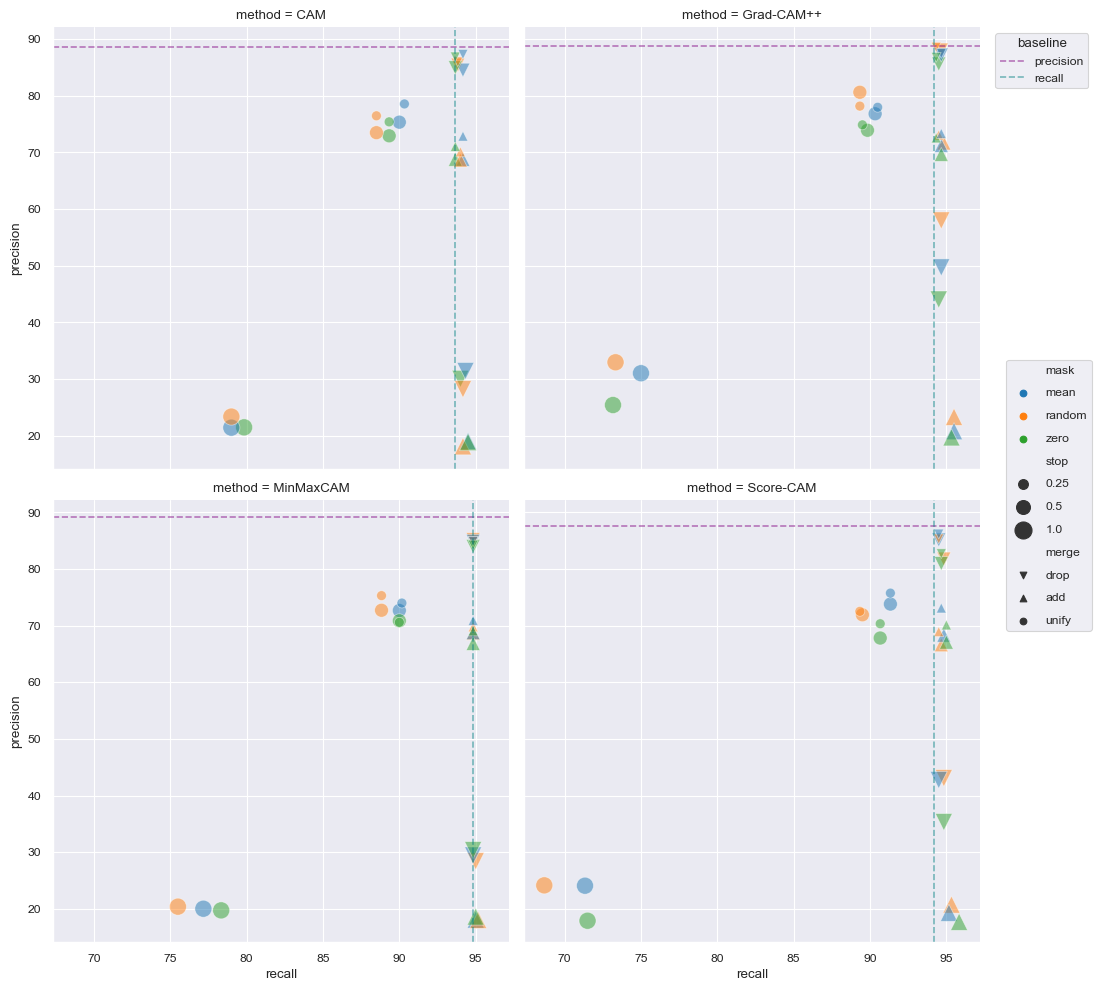

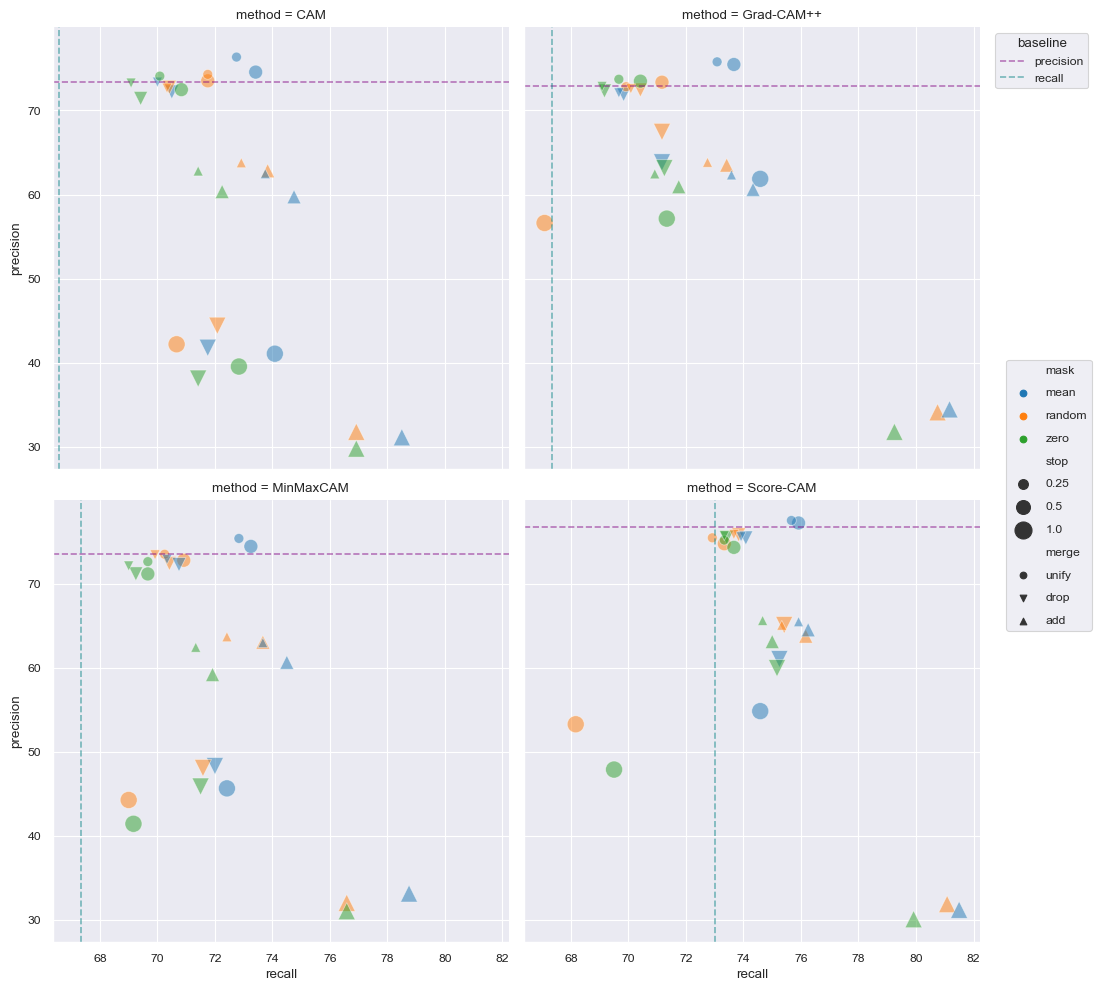

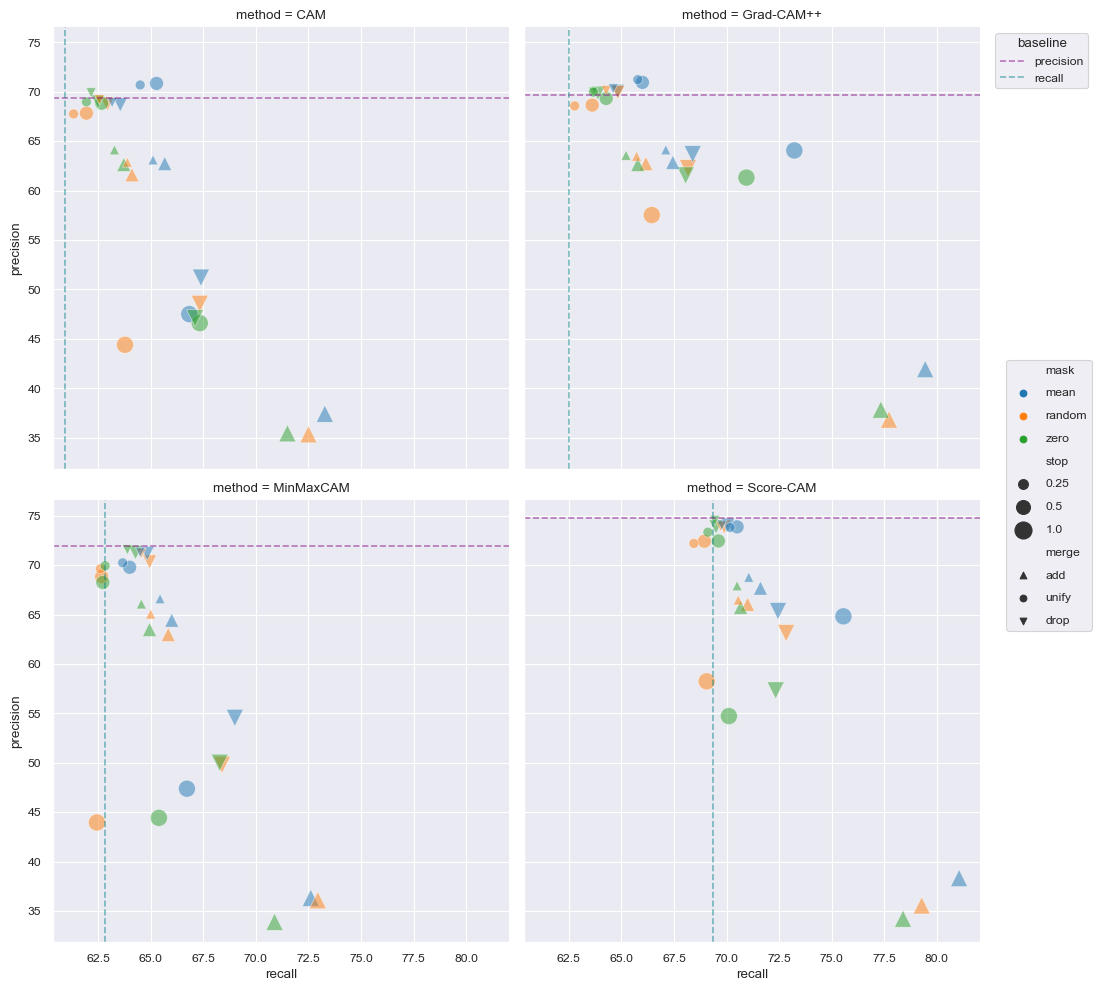

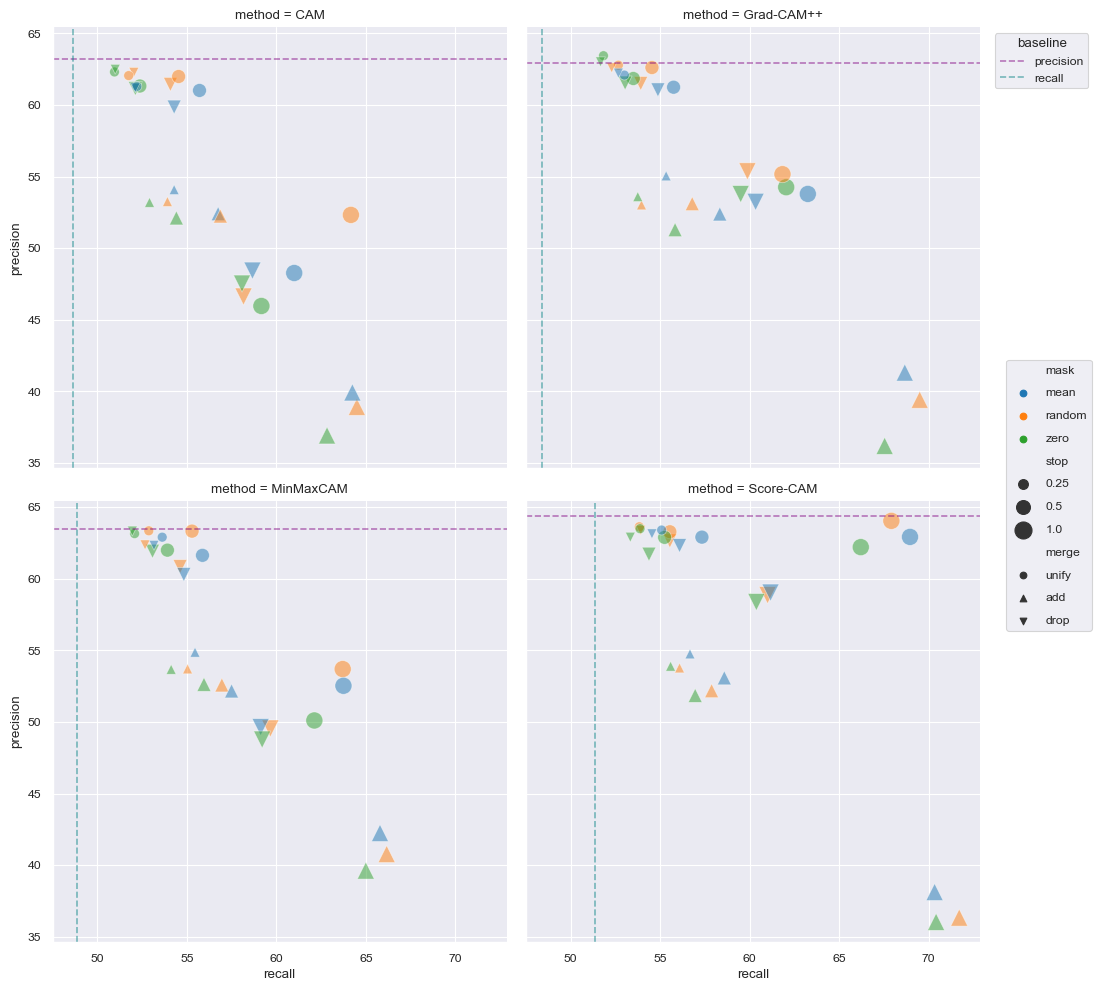

In [155]:
# baseline without iteration
experiment_name = 'mwsol_vgg16_synthetic'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
split = 'test'
df_base = mlflow_get_runs(experiment_name, conditions)
cols = ['tags.method', 'tags.dataset_spec',
        f'metrics.{split}_MaxBoxAccV3_f1', f'metrics.{split}_MaxBoxAccV3_precision', f'metrics.{split}_MaxBoxAccV3_recall']
cols_renamed = ['method', 'spec', 'f1', 'precision', 'recall']
df_base = df_base.loc[:, cols]
df_base = df_base.rename(columns=dict(zip(cols, cols_renamed)))
prec_base = df_base.set_index(['spec', 'method']).to_dict()

# iterative experiments
experiment_name = 'mwsol_vgg16_synthetic_iter'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
# conditions |= {
#     'params.bbox_mask_strategy': 'random',
#     'params.bbox_merge_strategy': 'add',
#     'params.iter_stop_prob_delta': '0.25',
# }
df = mlflow_get_runs(experiment_name, conditions)
cols = ['tags.method', 'tags.dataset_spec',
        'params.bbox_mask_strategy', 'params.bbox_merge_strategy', 'params.iter_stop_prob_delta',
        f'metrics.{split}_MaxBoxAccV3_f1', f'metrics.{split}_MaxBoxAccV3_precision', f'metrics.{split}_MaxBoxAccV3_recall']
cols_renamed = ['method', 'spec',
                'mask', 'merge', 'stop',
                'f1', 'precision', 'recall']
mapper = dict(zip(cols, cols_renamed))
df = df.loc[:, cols].rename(columns=mapper)
df = df.replace({'method': labels_methods})
for metric in ['precision', 'recall', 'f1']:
    df[metric] *= 100 # to percentage
df = df.sort_values(['method', 'spec'])
for spec in [f'd{i}b' for i in range(1,5)]:
    df2 = df.loc[(df['spec'] == spec)]
    sns.set_style("darkgrid")
    sns.set_context("paper")
    markers = {'drop': 'v', 'add': '^', 'unify':'o'}
    sizes = {'0.25': 50, '0.5': 100, '1.0': 150}
    size_order = ['0.25', '0.5', '1.0']
    hue_order = ['mean','random','zero']
    sns_fig = sns.relplot(data=df2, x="recall", y="precision", hue="mask", style="merge",
                          size="stop", size_order=size_order, col='method', col_wrap=2,
                          markers=markers, sizes=sizes, hue_order=hue_order, alpha=0.5)
    sns.move_legend(sns_fig, loc='center right', bbox_to_anchor=(1.02, 0.5), labelspacing=1.0, frameon=True)

    # flatten axes into a 1-d array
    axes = sns_fig.axes.flatten()
    # iterate through the axes
    methods = ['cam', 'gradcam++', 'minmaxcam', 'scorecam']
    for i, ax in enumerate(axes):
        method = methods[i]
        precision = prec_base['precision'][(spec, method)] * 100
        recall = prec_base['recall'][(spec, method)] * 100
        line_prec = ax.axhline(precision, ls='--', c='purple', label='precision', alpha=0.5)
        line_rec = ax.axvline(recall, ls='--', c='teal', label='recall', alpha=0.5)
        if i == 1:
            lines = [line_prec, line_rec]
            labels = ['precision', 'recall']
            legend = ax.legend(lines, labels, bbox_to_anchor=(1.02, 1.0), loc='upper left', title='baseline', frameon=True)
    sns_fig.savefig(f'fig_iter_vgg16_gap_syn_{spec}.png')

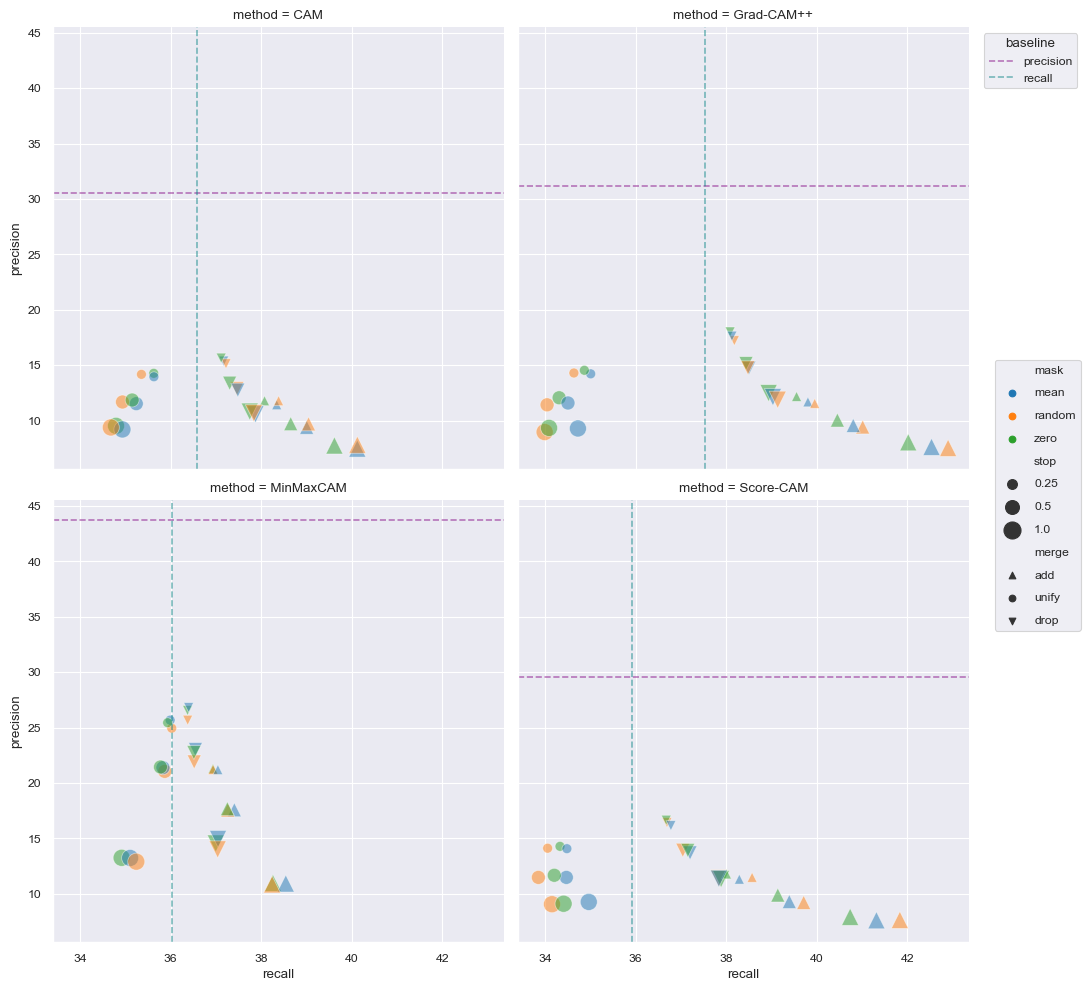

In [156]:
# baseline without iteration
experiment_name = 'mwsol_resnet50_imagenet'
conditions = {
    'tags.dataset': 'ILSVRC',
    'tags.architecture': 'resnet50',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
split = 'val'
df_base = mlflow_get_runs(experiment_name, conditions)
df_base = df_base.loc[df_base.start_time > '2023-05-01']
cols = ['tags.method',
        f'metrics.{split}_MaxBoxAccV3_f1', f'metrics.{split}_MaxBoxAccV3_precision', f'metrics.{split}_MaxBoxAccV3_recall']
cols_renamed = ['method', 'f1', 'precision', 'recall']
df_base = df_base.loc[:, cols]
df_base = df_base.rename(columns=dict(zip(cols, cols_renamed)))
prec_base = df_base.set_index(['method']).to_dict()

# iterative experiments
experiment_name = 'mwsol_resnet50_imagenet_iter'
conditions = {
    'tags.dataset': 'ILSVRC',
    'tags.architecture': 'resnet50',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
# conditions |= {
#     'params.bbox_mask_strategy': 'random',
#     'params.bbox_merge_strategy': 'add',
#     'params.iter_stop_prob_delta': '0.25',
# }
df = mlflow_get_runs(experiment_name, conditions)
cols = ['tags.method',
        'params.bbox_mask_strategy', 'params.bbox_merge_strategy', 'params.iter_stop_prob_delta',
        f'metrics.{split}_MaxBoxAccV3_f1', f'metrics.{split}_MaxBoxAccV3_precision', f'metrics.{split}_MaxBoxAccV3_recall']
cols_renamed = ['method',
                'mask', 'merge', 'stop',
                'f1', 'precision', 'recall']
mapper = dict(zip(cols, cols_renamed))
df = df.loc[:, cols].rename(columns=mapper)
df = df.replace({'method': labels_methods})
for metric in ['precision', 'recall', 'f1']:
    df[metric] *= 100 # to percentage
df = df.sort_values(['method'])

sns.set_style("darkgrid")
sns.set_context("paper")
markers = {'drop': 'v', 'add': '^', 'unify':'o'}
# markers = {'drop': 'x', 'add': '+', 'unify':'2'}
sizes = {'0.25': 50, '0.5': 100, '1.0': 150}
size_order = ['0.25', '0.5', '1.0']
hue_order = ['mean','random','zero']
sns_fig = sns.relplot(data=df, x="recall", y="precision", hue="mask", style="merge",
                      size="stop", size_order=size_order, col='method', col_wrap=2,
                      markers=markers, sizes=sizes, hue_order=hue_order, alpha=0.5)
sns.move_legend(sns_fig, loc='center right', bbox_to_anchor=(1.02, 0.5), labelspacing=1.0, frameon=True)
# flatten axes into a 1-d array
axes = sns_fig.axes.flatten()
# iterate through the axes
methods = ['cam', 'gradcam++', 'minmaxcam', 'scorecam']
for i, ax in enumerate(axes):
    method = methods[i]
    precision = prec_base['precision'][method] * 100
    recall = prec_base['recall'][method] * 100
    line_prec = ax.axhline(precision, ls='--', c='purple', label='precision', alpha=0.5)
    line_rec = ax.axvline(recall, ls='--', c='teal', label='recall', alpha=0.5)
    if i == 1:
        lines = [line_prec, line_rec]
        labels = ['precision', 'recall']
        legend = ax.legend(lines, labels, bbox_to_anchor=(1.02, 1.0), loc='upper left', title='baseline', frameon=True)
sns_fig.savefig(f'fig_iter_resnet50_imagenet.png')